# SEQUENTIAL MACHINE LEARNING
This notebook will focus on how to implement and apply both a simple _recurrent neural network_ (RNN) and a simple _long short term memory RNN_ (LSTM) on **sequential data**.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# SEQUENTIAL MACHINE LEARNING: Sine Simulation
Before evaluating a model on a real, time series dataset, I'd like to test implementation details on a sine wave as a simulated sequential dataset.

### Data

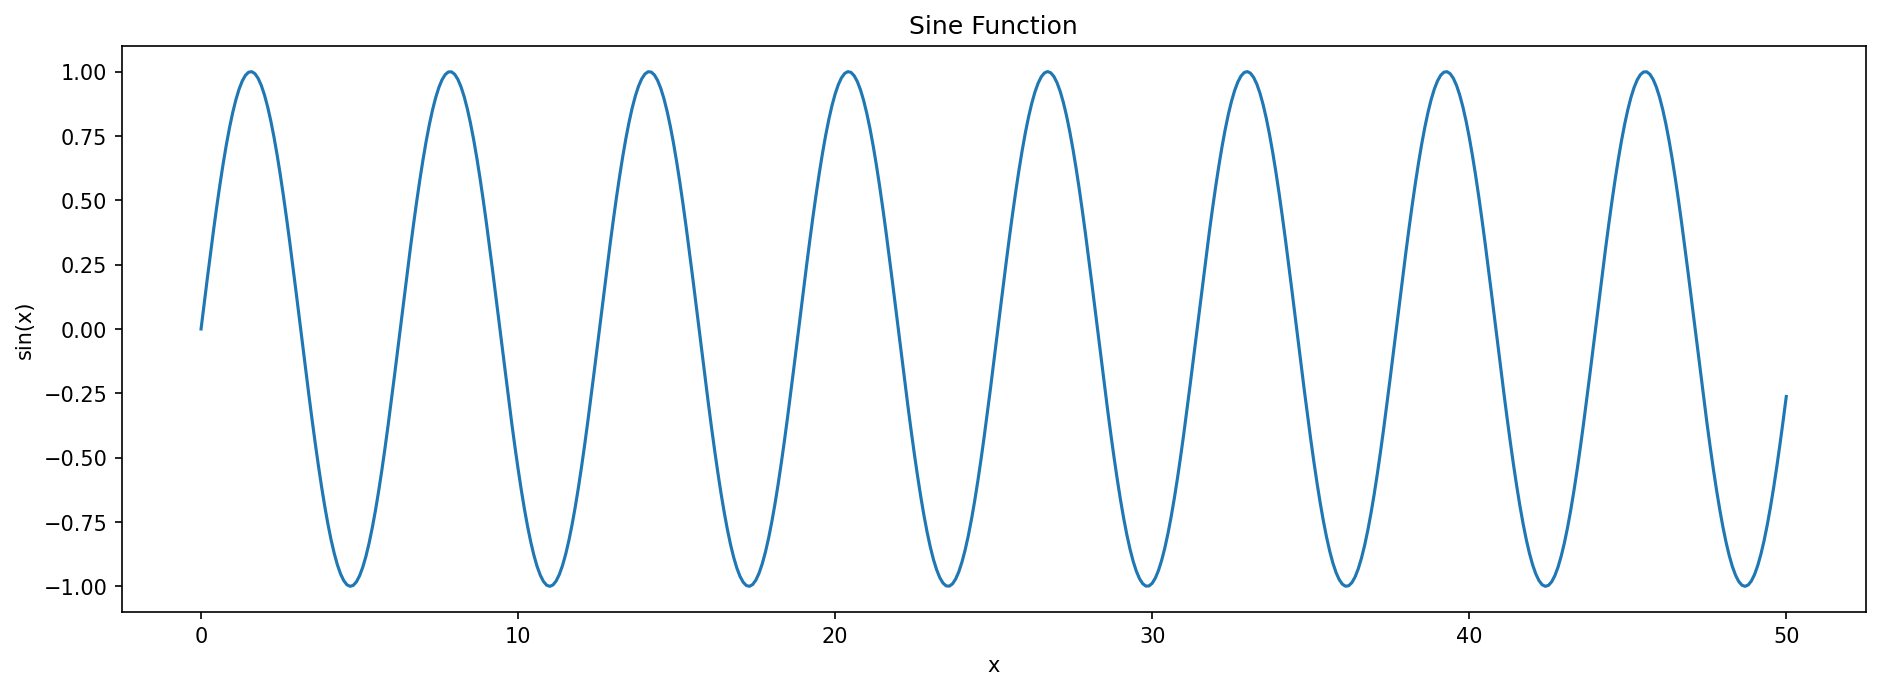

In [2]:
# Generate data
x = np.linspace(0, 50, 501)
y = np.sin(x)

# Plot data
plt.figure(figsize=(15, 5), dpi=150)
plt.plot(x, y)
plt.title("Sine Function")
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.show()

In [3]:
# Split data
TEST_SIZE = 0.1

data_seq = pd.DataFrame(data=y, index=x, columns=['Sine'])
test_idx = int(data_seq.shape[0] * (1 - TEST_SIZE))

train_seq = data_seq.iloc[:test_idx]
test_seq  = data_seq.iloc[test_idx:]

# Normalize data
scaler = MinMaxScaler().fit(train_seq)
scaled_train = scaler.transform(train_seq)
scaled_test = scaler.transform(test_seq)

print(f"TRAIN: First {scaled_train.shape[0]} samples")
print(f"TEST: Last {scaled_test.shape[0]} samples")

TRAIN: First 450 samples
TEST: Last 51 samples


In [4]:
# Create generators to preprocess and augment training and test data
SEQ_LENGTH = 50
BATCH_SIZE = 1

training_generator = TimeseriesGenerator(
    data=scaled_train,
    targets=scaled_train,
    length=SEQ_LENGTH,
    batch_size=BATCH_SIZE)

test_generator = TimeseriesGenerator(
    data=scaled_test,
    targets=scaled_test,
    length=SEQ_LENGTH,
    batch_size=BATCH_SIZE,
    shuffle=False)

### Model: RNN

In [5]:
# Simple RNN architecture
N_FEATURES = 1
model = Sequential(name='simple_rnn')

model.add(SimpleRNN(units=SEQ_LENGTH, input_shape=(SEQ_LENGTH, N_FEATURES)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "simple_rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Train model
history = model.fit(training_generator, epochs=10)

Epoch 1/10


2022-05-19 12:48:19.341619: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


400/400 [==============================] - 1s 3ms/step - loss: 0.0067
Epoch 2/10
400/400 [==============================] - 1s 3ms/step - loss: 1.7920e-04
Epoch 3/10
400/400 [==============================] - 1s 3ms/step - loss: 7.0154e-05
Epoch 4/10
400/400 [==============================] - 1s 3ms/step - loss: 1.0068e-04
Epoch 5/10
400/400 [==============================] - 1s 3ms/step - loss: 1.1386e-04
Epoch 6/10
400/400 [==============================] - 1s 3ms/step - loss: 2.1701e-05
Epoch 7/10
400/400 [==============================] - 1s 3ms/step - loss: 2.4791e-05
Epoch 8/10
400/400 [==============================] - 1s 3ms/step - loss: 1.1248e-04
Epoch 9/10
400/400 [==============================] - 1s 3ms/step - loss: 2.3645e-04
Epoch 10/10
400/400 [==============================] - 1s 3ms/step - loss: 3.0408e-06


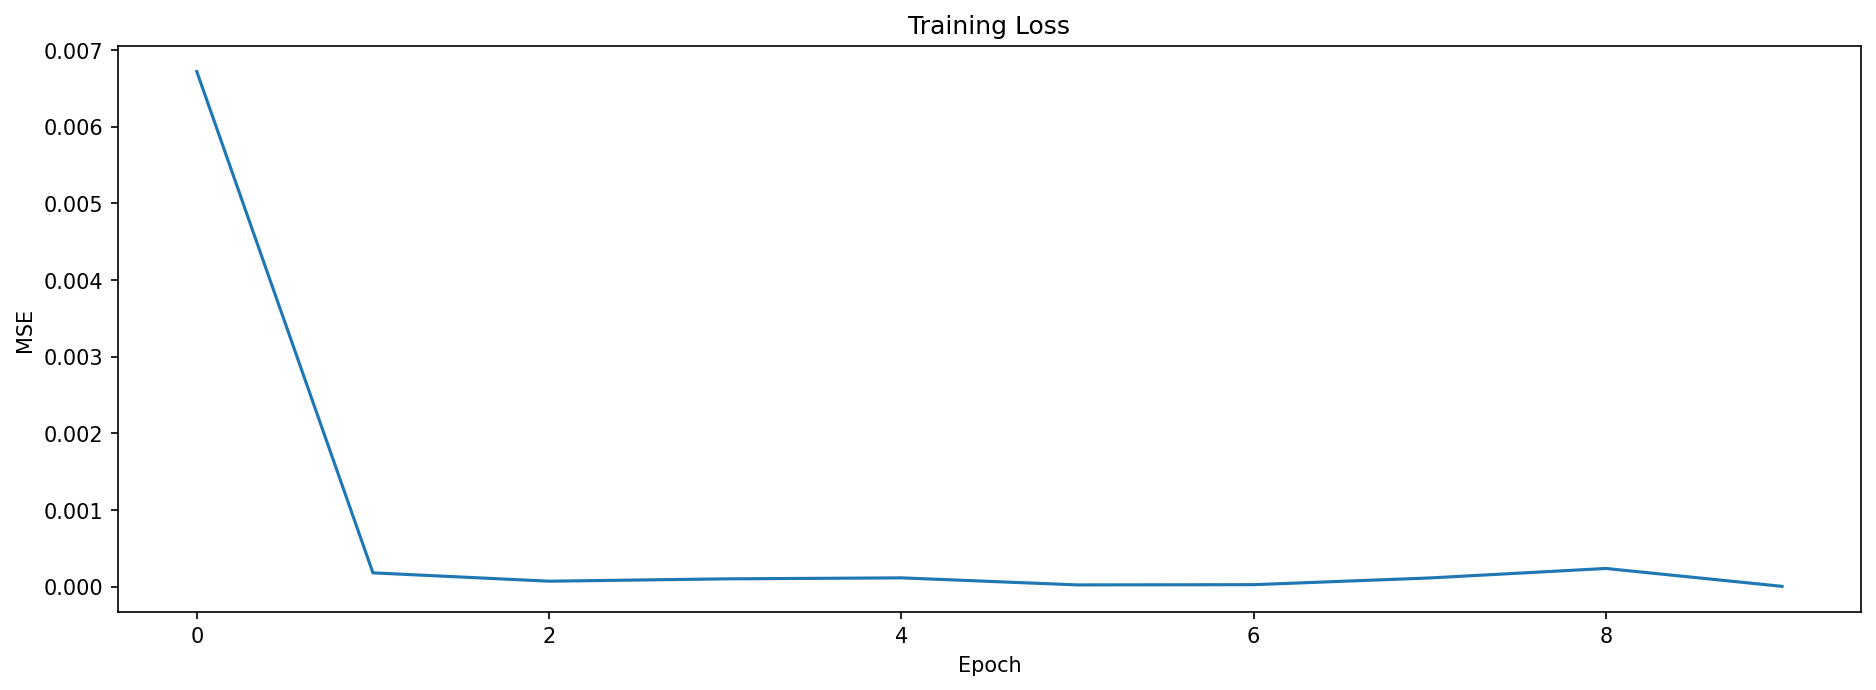

In [7]:
# Plot losses
plt.figure(figsize=(15, 5), dpi=150)
plt.plot(pd.DataFrame(history.history))
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

In [8]:
# Evaluate model
pred_all = []

eval_seq = scaled_train[-SEQ_LENGTH:]
curr_seq = eval_seq.reshape((1, SEQ_LENGTH, N_FEATURES))

for _ in range(len(test_seq)):
    pred_seq = model.predict(curr_seq)[0]
    curr_seq = np.append(curr_seq[:, 1:, :], [[pred_seq]], axis=1)
    pred_all.append(pred_seq)

In [9]:
pd.options.mode.chained_assignment = None # safely disable DataFrame copy warning

# Denormalize predictions
pred_all = scaler.inverse_transform(pred_all)
test_seq['Predictions'] = pred_all
test_seq

,Sine,Predictions
45.0,0.850904,0.844575
45.1,0.899097,0.891014
45.2,0.938307,0.926697
45.3,0.968142,0.952018
45.4,0.988304,0.968463
45.5,0.998591,0.975135
45.6,0.998900,0.972230
45.7,0.989229,0.958140
45.8,0.969673,0.934901
45.9,0.940429,0.903121


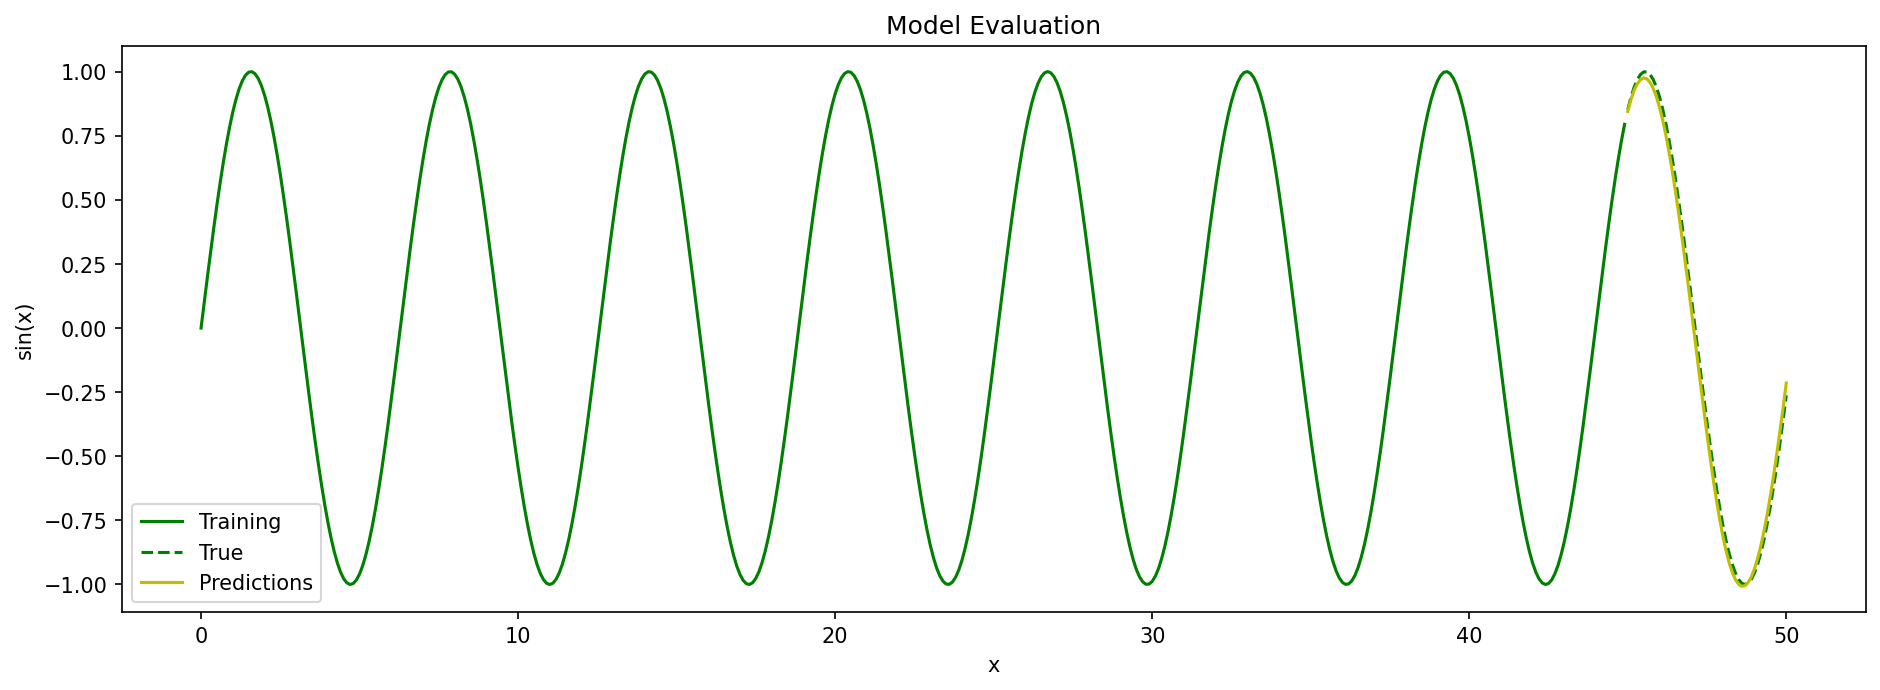

In [10]:
# Plot predictions vs. ground truth
plt.figure(figsize=(15, 5), dpi=150)

plt.plot(train_seq['Sine'], label='Training', c='g')
plt.plot(test_seq['Sine'], label='True', c='g', linestyle='--')
plt.plot(test_seq['Predictions'], label='Predictions', c='y')

plt.title("Model Evaluation")
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.legend(loc='lower left')
plt.show()

# SEQUENTIAL MACHINE LEARNING: FOREX
This dataset has EUR/USD FOREX trading data from May 5, 2003 to Oct 16, 2021. For every 4-hour period, it includes open/close/high/low values, as well as total volume.
<br>
Original Source: [FOREX](https://forex.tradingcharts.com/)
Download Source: [Kaggle](https://www.kaggle.com/datasets/chandrimad31/eurusd-forex-trading-data-20032021)

### Data

In [11]:
# Import data (see sources above)
forex = pd.read_csv('data/forex.csv', parse_dates=True, index_col='Gmt time')
forex.head()

,open,high,low,close,volume
Gmt time,,,,,
2003-04-05 21:00:00,1.12354,1.12354,1.12166,1.12274,95533.0976
2003-05-05 01:00:00,1.12242,1.12276,1.12067,1.12126,93778.5996
2003-05-05 05:00:00,1.12139,1.12255,1.12030,1.12113,90924.6992
2003-05-05 09:00:00,1.12092,1.12331,1.12049,1.12174,91254.6992
2003-05-05 13:00:00,1.12194,1.12900,1.12130,1.12712,308003.4083


In [12]:
# 5-number summary
forex.describe()

,open,high,low,close,volume
count,28860.000000,28860.000000,28860.000000,28860.000000,28860.000000
mean,1.254449,1.256497,1.252384,1.254457,83078.835388
std,0.119505,0.119839,0.119131,0.119503,100637.239637
min,1.036930,1.039200,1.034050,1.036970,0.000000
25%,1.154278,1.155988,1.152438,1.154285,20322.189925
50%,1.242230,1.244390,1.239885,1.242260,47812.714850
75%,1.338760,1.340750,1.336512,1.338763,102454.949700
max,1.599500,1.604030,1.596950,1.599240,752269.093800


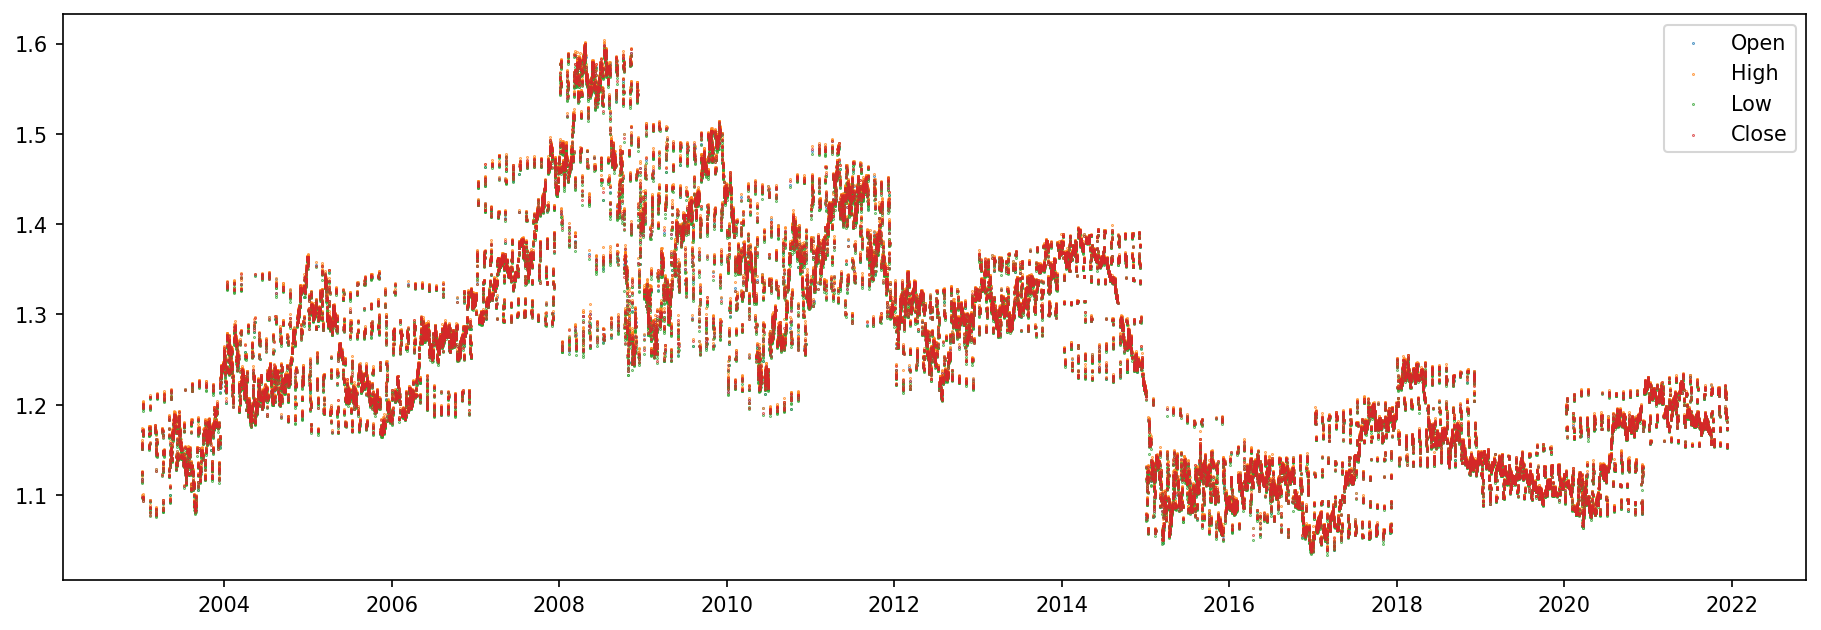

In [27]:
plt.figure(figsize=(15, 5), dpi=150)
plt.scatter(forex.index, forex.open, s=.1, label='Open')
plt.scatter(forex.index, forex.high, s=.1, label='High')
plt.scatter(forex.index, forex.low, s=.1, label='Low')
plt.scatter(forex.index, forex.close, s=.1, label='Close')
plt.legend()
plt.show()

In [28]:
# Split data
TEST_SIZE = 0.15

split = int(forex.shape[0] * (1 - TEST_SIZE))

train_seq = forex.iloc[:split]
test_seq  = forex.iloc[split:]

# Normalize data
scaler = MinMaxScaler().fit(train_seq)
scaled_train = scaler.transform(train_seq)
scaled_test = scaler.transform(test_seq)

print(f"TRAIN: First {scaled_train.shape[0]} samples")
print(f"TEST: Last {scaled_test.shape[0]} samples")

TRAIN: First 24531 samples
TEST: Last 4329 samples


In [29]:
# Create generators to preprocess and augment training and test data
SEQ_LENGTH = 50
BATCH_SIZE = 1

training_generator = TimeseriesGenerator(
    data=scaled_train,
    targets=scaled_train,
    length=SEQ_LENGTH,
    batch_size=BATCH_SIZE)

test_generator = TimeseriesGenerator(
    data=scaled_test,
    targets=scaled_test,
    length=SEQ_LENGTH,
    batch_size=BATCH_SIZE,
    shuffle=False)

In [30]:
# Simple RNN architecture
N_FEATURES = 5
model = Sequential(name='simple_rnn')

model.add(SimpleRNN(units=SEQ_LENGTH, input_shape=(SEQ_LENGTH, N_FEATURES)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "simple_rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 50)                2800      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,851
Trainable params: 2,851
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Train model
history = model.fit(training_generator, epochs=10)

Epoch 1/10
24481/24481 [==============================] - 69s 3ms/step - loss: 0.0253
Epoch 2/10
24481/24481 [==============================] - 71s 3ms/step - loss: 0.0249
Epoch 3/10
24481/24481 [==============================] - 70s 3ms/step - loss: 0.0249
Epoch 4/10
24481/24481 [==============================] - 69s 3ms/step - loss: 0.0249
Epoch 5/10
24481/24481 [==============================] - 68s 3ms/step - loss: 0.0249
Epoch 6/10
24481/24481 [==============================] - 68s 3ms/step - loss: 0.0249
Epoch 7/10
24481/24481 [==============================] - 69s 3ms/step - loss: 0.0249
Epoch 8/10
24481/24481 [==============================] - 70s 3ms/step - loss: 0.0249
Epoch 9/10
24481/24481 [==============================] - 70s 3ms/step - loss: 0.0249
Epoch 10/10
24481/24481 [==============================] - 70s 3ms/step - loss: 0.0249


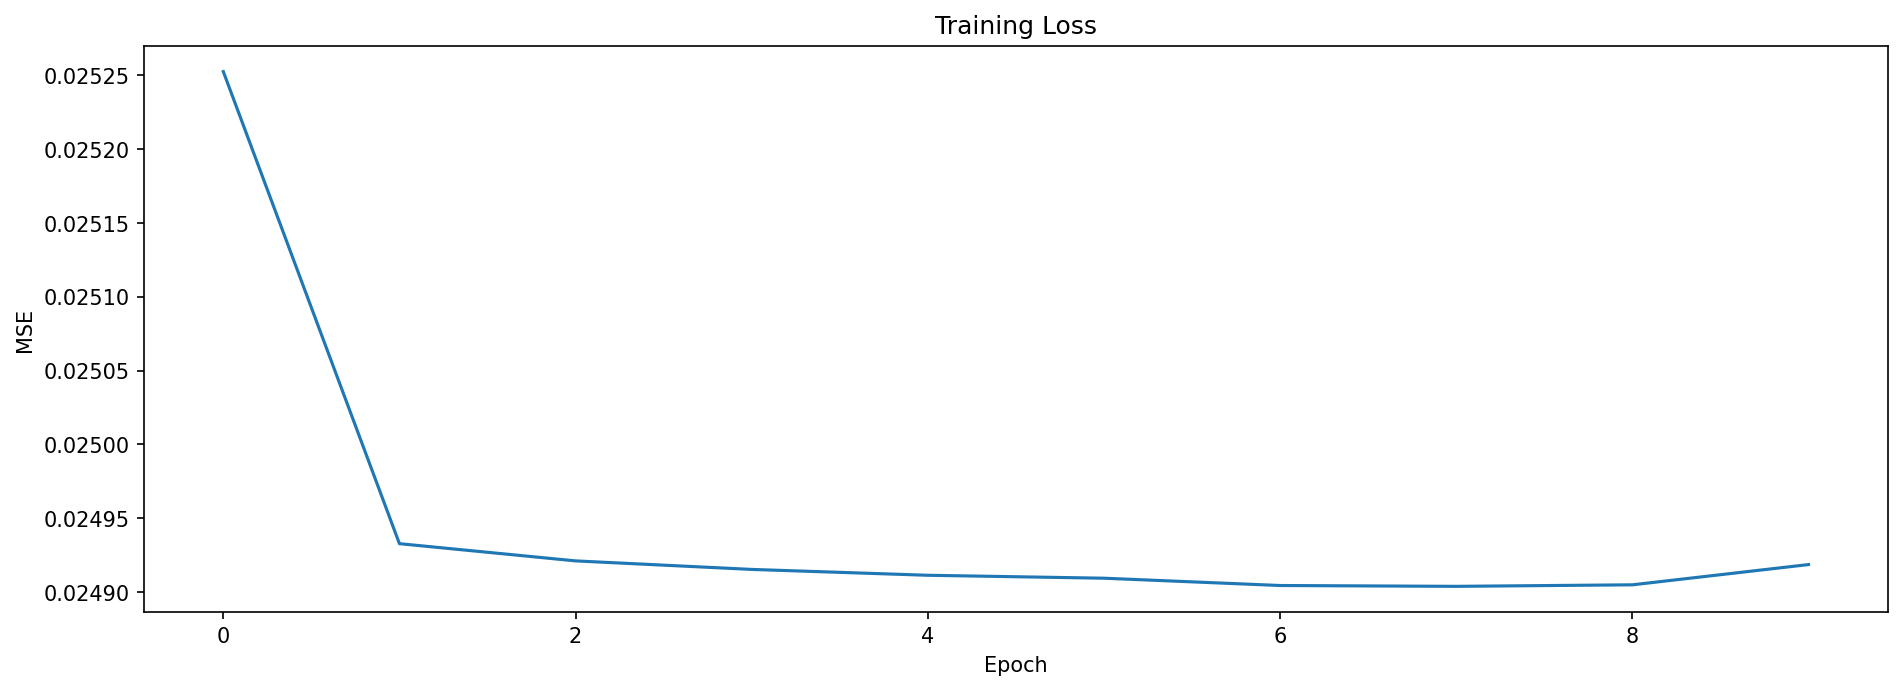

In [32]:
# Plot losses
plt.figure(figsize=(15, 5), dpi=150)
plt.plot(pd.DataFrame(history.history))
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

In [35]:
# Evaluate model
pred_all = []

eval_seq = scaled_train[-SEQ_LENGTH:]
curr_seq = eval_seq.reshape((1, SEQ_LENGTH, N_FEATURES))

for _ in range(len(test_seq)):
    pred_seq = model.predict(curr_seq)[0]
    curr_seq = np.append(curr_seq[:, 1:, :], [[pred_seq]], axis=1)
    pred_all.append(pred_seq)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 5 and the array at index 1 has size 1